In [1]:
# # On the Effective Horizon of Inverse Reinforcement Learning
# 
# This notebook demonstrates example usage of the IRL environment and algorithms:
# 1. Creating a simple Gridworld environment.
# 2. Generating partial expert demonstrations.
# 3. Running Linear Programming IRL.
# 4. Running Maximum Entropy IRL.
# 5. Evaluating and visualizing the results.
# ---

import numpy as np
import matplotlib.pyplot as plt


from irl.mdp.gridworld import Gridworld
from irl.mdp.objectworld import Objectworld
from effective_horizon_lp import lp_env_init, lp_irl
from effective_horizon_maxent import load_maxent_expert, maxent_irl
#
# If they're in a different location, you'll need to adjust the imports accordingly.

# For this demo, let's illustrate usage with a simple Gridworld and the provided IRL methods.

# ---
# ## 1. Creating a Gridworld environment and generating expert data
# ---

def demo_gridworld():
    """
    Creates a Gridworld environment (simple), 
    samples expert demonstrations, 
    and returns them for use in IRL.
    """
    # Example: A 10x10 simple Gridworld
    # If you are using exactly the same environment structure from the README,
    # the environment might be created differently. Adjust accordingly.
    
    # environment = Gridworld(grid_size=10, reward_model="simple", seed=0)
    # For demonstration, let's emulate the environment interface.
    
    print("Creating a 10x10 'simple' Gridworld with seed=0 ...")
    
    # Example from the `lp_env_init` function in the README:
    task = "gridworld"
    expert_fraction = 0.5  # 50% of expert data
    seed = 42
    reward_model = "simple"
    
    # The lp_env_init function is supposed to initialize everything for LP IRL. 
    # Let's do that here:
    print("Initializing environment and partial demonstrations for LP IRL...")
    env_data = lp_env_init(
        task=task,
        expert_fraction=expert_fraction,
        seed=seed,
        reward_model=reward_model
    )
    
    (world_env, ground_r, expert_policy, expert_demonstrated_states) = env_data
    
    print("\nEnvironment initialized. Found partial expert demonstrations:")
    print(f" - Number of demonstrated states: {len(expert_demonstrated_states)}")
    
    return world_env, ground_r, expert_policy, expert_demonstrated_states


world_env, ground_r, expert_policy, expert_demonstrated_states = demo_gridworld()


Creating a 10x10 'simple' Gridworld with seed=0 ...
Initializing environment and partial demonstrations for LP IRL...
finished computing V-value
finished computing the expert policy

Environment initialized. Found partial expert demonstrations:
 - Number of demonstrated states: 50


In [2]:
# ---
# ## 2. Running Linear Programming IRL
# ---

def run_lp_irl(world_env, expert_demonstrated_states, discount=0.5, slack=0.001):
    """
    Runs Linear Programming IRL with a given discount factor
    and returns the learned reward, value, and policy.
    """
    print(f"\nRunning LP IRL with discount={discount}, slack={slack} ...")
    estimate_r, learned_v, learned_policy = lp_irl(
        world_env,
        expert_demonstrated_states,
        discount,
        slack_variable=slack
    )
    print("LP IRL completed.")
    return estimate_r, learned_v, learned_policy

lp_estimated_r, lp_v, lp_policy = run_lp_irl(
    world_env, 
    expert_demonstrated_states, 
    discount=0.5, 
    slack=0.001
)


Running LP IRL with discount=0.5, slack=0.001 ...
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4406e-02 -2.4138e+02  3e+03  3e+00  4e+01  1e+00
 1:  2.4079e-01 -4.4665e+01  3e+02  6e-01  7e+00  1e+00
 2: -6.2401e+00 -4.5607e+01  3e+02  5e-01  6e+00  1e+00
 3: -8.2257e+00 -4.5272e+01  3e+02  5e-01  6e+00  8e-01
 4: -1.7941e+01 -3.6414e+01  1e+02  2e-01  3e+00  3e-01
 5: -2.5842e+01 -3.4697e+01  6e+01  1e-01  1e+00  1e-01
 6: -2.9434e+01 -3.4104e+01  3e+01  6e-02  7e-01  5e-02
 7: -3.3047e+01 -3.4260e+01  8e+00  2e-02  2e-01  6e-03
 8: -3.4072e+01 -3.4469e+01  3e+00  5e-03  6e-02  2e-03
 9: -3.4461e+01 -3.4587e+01  8e-01  2e-03  2e-02  5e-04
10: -3.4463e+01 -3.4586e+01  8e-01  2e-03  2e-02  5e-04
11: -3.4537e+01 -3.4601e+01  4e-01  8e-04  1e-02  2e-04
12: -3.4597e+01 -3.4621e+01  2e-01  3e-04  4e-03  8e-05
13: -3.4621e+01 -3.4629e+01  5e-02  1e-04  1e-03  3e-05
14: -3.4622e+01 -3.4629e+01  5e-02  1e-04  1e-03  2e-05
15: -3.4629e+01 -3.4631e+01  1e-02  3e-05  3e-04  8e-06

In [7]:
# ---
# ## 3. Running Maximum Entropy IRL
# 
# For Maximum Entropy IRL, we use 'load_maxent_expert' to retrieve the required 
# environment data. We'll then call 'maxent_irl' with a specified horizon.
# ---
import numpy.random as rn
import numpy as np

def demo_maxent(task_env="gridworld", mode="single", reward_model="simple", horizon=10):
    """
    Demonstrates loading environment data for MaxEnt IRL and running the IRL algorithm.
    """
    print(f"\nLoading MaxEnt environment for {task_env} in {mode} mode with reward='{reward_model}'...")
    (transition_fn, _states, _actions, trajs, feature_matrix, 
     n_actions, n_states, _) = load_maxent_expert(
         task_env=task_env, 
         mode=mode, 
         reward_model=reward_model
     )


    # extract training traj with N randomly sample initial states and truncate the trajectories at the given training horizon
    init_states = rn.choice(range(100), 10, replace=False)
    training_trajs = np.array([trajs[i] for i in init_states])[:, :horizon]

    print("Running Maximum Entropy IRL...")
    estimate_r, learned_v, policy = maxent_irl(
        feature_matrix,
        n_states,
        n_actions,
        transition_fn,
        training_trajs,
        epochs=50,          # Lower epochs for a quick demo
        learning_rate=0.01, # Example learning rate
        finite_horizon=horizon
    )
    print("MaxEnt IRL completed.")
    return estimate_r, learned_v, policy

maxent_estimated_r, maxent_v, maxent_policy = demo_maxent(
    task_env="gridworld", 
    mode="single", 
    reward_model="simple", 
    horizon=10
)


Loading MaxEnt environment for gridworld in single mode with reward='simple'...
Running Maximum Entropy IRL...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.17it/s]


MaxEnt IRL completed.



Visualizing the learned rewards...


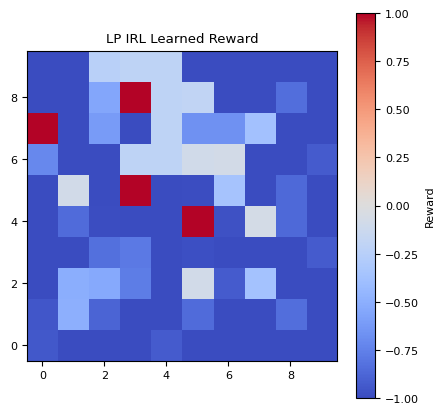

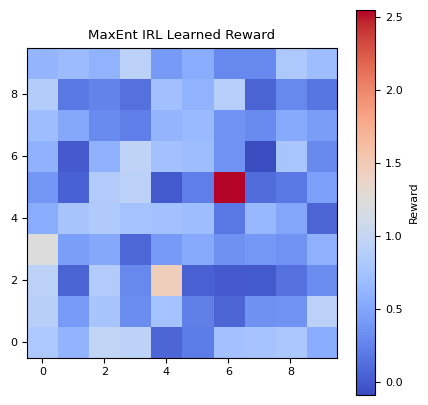

In [8]:
# ---
# ## 4. Quick Comparison and Visualization
# 
# Note: Visualization depends on how your environment is structured. 
# If you have a grid, you can plot the reward values as a heatmap.
# ---

def visualize_reward(reward_array, title="Learned Reward", grid_size=10):
    """
    Utility function to visualize a reward array on a grid.
    reward_array: shape (grid_size * grid_size,) or (n_states,)
    """
    # Convert to 2D array for easier plotting
    reward_2d = reward_array.reshape((grid_size, grid_size))
    
    plt.figure(figsize=(5, 5))
    plt.imshow(reward_2d, cmap='coolwarm', origin='lower')
    plt.colorbar(label="Reward")
    plt.title(title)
    plt.show()

# If your environment does not store grid_size, 
# you'll need to adapt this value to match the environment's state space.

grid_size = 10  # For this demo, we assume a 10x10 Gridworld.

print("\nVisualizing the learned rewards...")

# Visualize LP IRL Reward
visualize_reward(lp_estimated_r, title="LP IRL Learned Reward", grid_size=grid_size)

# Visualize MaxEnt IRL Reward
visualize_reward(maxent_estimated_r, title="MaxEnt IRL Learned Reward", grid_size=grid_size)
